<h1><strong><u>Logistic Regression Test</u></strong><h1>

In [1]:
%%capture
%run DataPrep.ipynb

<h2><strong><u>Logistic Regression Model Selection</u></strong><h2>

<h3><strong><u>Validation Curve Test</u></strong></h3>

In [ ]:
for title, metric in clf_metrics.items():
    pipeline = ImbLearn_Pipeline(
        [
            ("vect", TfidfVectorizer(tokenizer=custom_tokenizer, token_pattern=None)),
            ("samp", SMOTE(random_state=3)),
            ("clf", LogisticRegression())
        ]
    ) 

    alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10]
    train_scores, validation_scores = validation_curve(pipeline, X_train, y_train, cv=5, scoring=metric,
                                                    param_name="clf__C",
                                                    param_range=alphas,
                                                    n_jobs=-1)
    train_scores_mean = np.mean(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)

    vc_plot_dict[f"Logistic Regession: {title} VC"] = [alphas, 
                                                       [train_scores_mean, validation_scores_mean], 
                                                       ["Regularization Coefficient", title],]

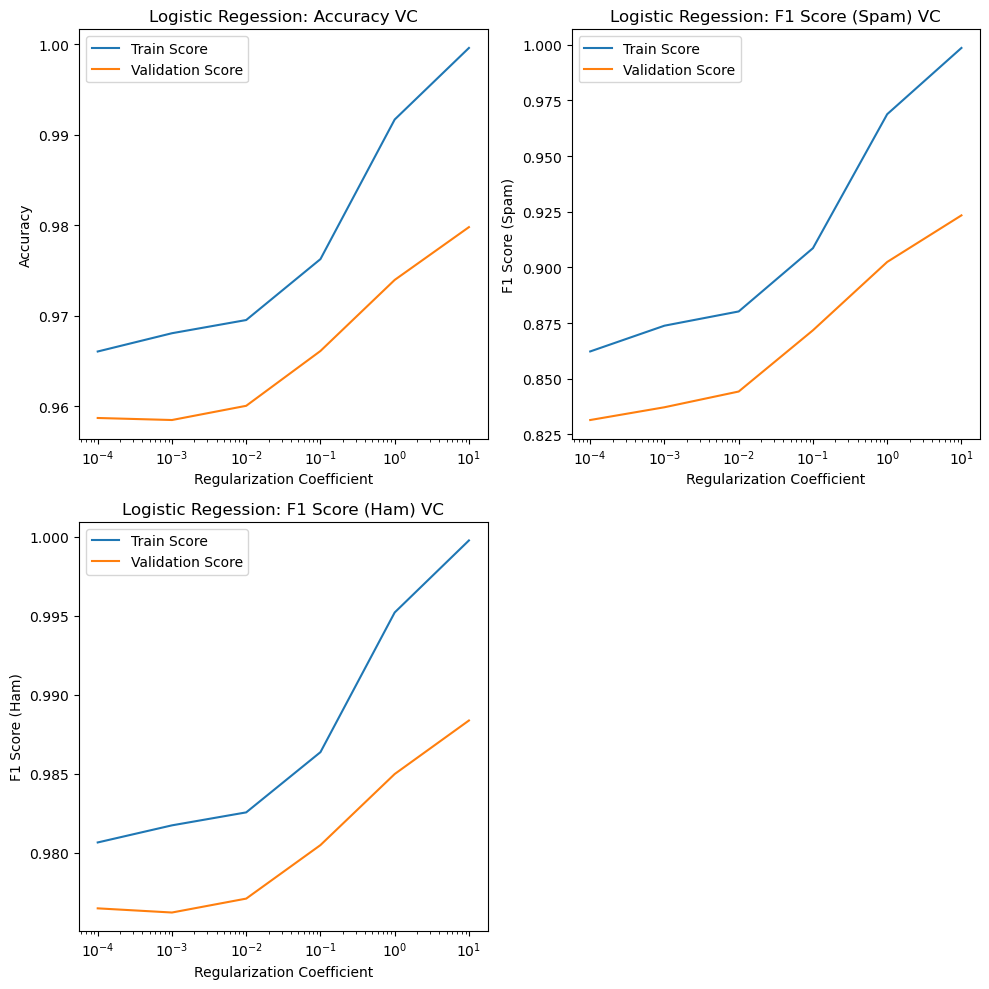

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Flatten the axes array for easier iteration
axs = axs.flatten()
count = 0
for key, value in vc_plot_dict.items():
    axs[count].semilogx(value[0], value[1][0], label="Train Score")
    axs[count].semilogx(value[0], value[1][1],  label="Validation Score")
    axs[count].set_xlabel(value[2][0])
    axs[count].set_ylabel(value[2][1])
    axs[count].set_title(key)
    axs[count].legend()
    count += 1

# Delete the unused subplot (e.g., the last one for a 3x2 grid with 5 plots)
fig.delaxes(axs[count]) 

plt.tight_layout()
plt.show()

<h3><strong><u>Cross-Validation Test</u></strong></h3>

In [ ]:
pipeline = ImbLearn_Pipeline(
    [
        ("vect", TfidfVectorizer(tokenizer=custom_tokenizer, token_pattern=None)),
        ("samp", SMOTE(random_state=3)),
        ("clf", LogisticRegression())
    ]
) 
param_grid = {"clf__C": [0.1, 0.3, 0.5, 0.7, 0.9, 1]}
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring=custom_f1_scorer_spam)
grid_search.fit(X_train, y_train)
print("Best Parameters: ", grid_search.best_params_)
log_model = grid_search.best_estimator_

def log_spam_classifier():
    return log_model

Best Parameters:  {'clf__C': 1}
Pipeline(steps=[('vect',
                 TfidfVectorizer(token_pattern=None,
                                 tokenizer=<function custom_tokenizer at 0x16388f6a0>)),
                ('samp', SMOTE(random_state=3)),
                ('clf', LogisticRegression(C=1))])


<h4><strong><u>Findings From 'Model Selection' Section</u></strong></h4>
The scoring metrics that I used for the Grid Search cross-validation test was the f1 score with 'spam' as the positive class. F1 score is a good method to access the model's performance especially for imbalanced dataset or synthetically balanced datasets. Switching between the RandomUnderSampler function and SMOTE while using a logarithmic range of regularization coefficients, I found that SMOTE performed better than the RandomUnderSampling function on the f1 scores. The curves suggest that very high C/low regularization will likely lead to overfitting. For the regularization coefficient, I found that the best regularization coefficient will mostly likely be 1. Therefore, I used a small range of regularization coefficients that included 1.

<h2><strong><u>Model Evaluation</u></strong></h2>

<h3><strong><u>Learning Curve Tests</u></strong></h3>

In [7]:
for key, value in clf_metrics.items():
    logistic_train_sizes, logistic_train_scores, logistic_validation_scores = learning_curve(
        log_model,
        X_train,
        y_train,
        cv=5,  # Number of folds for cross-validation
        scoring=value,  # Metric to evaluate the model
        n_jobs=-1,  # Use all available CPU cores
    )

    # Calculate mean and standard deviation for scores
    logistic_train_scores_mean = np.mean(logistic_train_scores, axis=1)
    logistic_train_scores_std = np.std(logistic_train_scores, axis=1)
    logistic_validation_scores_mean = np.mean(logistic_validation_scores, axis=1)
    logistic_validation_scores_std = np.std(logistic_validation_scores, axis=1)

    # Calculate spread of data around the mean
    logistic_train_range_minus = logistic_train_scores_mean - logistic_train_scores_std
    logistic_train_range_plus = logistic_train_scores_mean + logistic_train_scores_std
    logistic_validation_range_minus = logistic_validation_scores_mean - logistic_validation_scores_std
    logistic_validation_range_plus = logistic_validation_scores_mean + logistic_validation_scores_std

    lc_dict[key] = [[logistic_train_scores_mean, logistic_validation_scores_mean],
                    [logistic_train_range_minus, logistic_train_range_plus], 
                    [logistic_validation_range_minus, logistic_validation_range_plus], 
                    logistic_train_sizes]

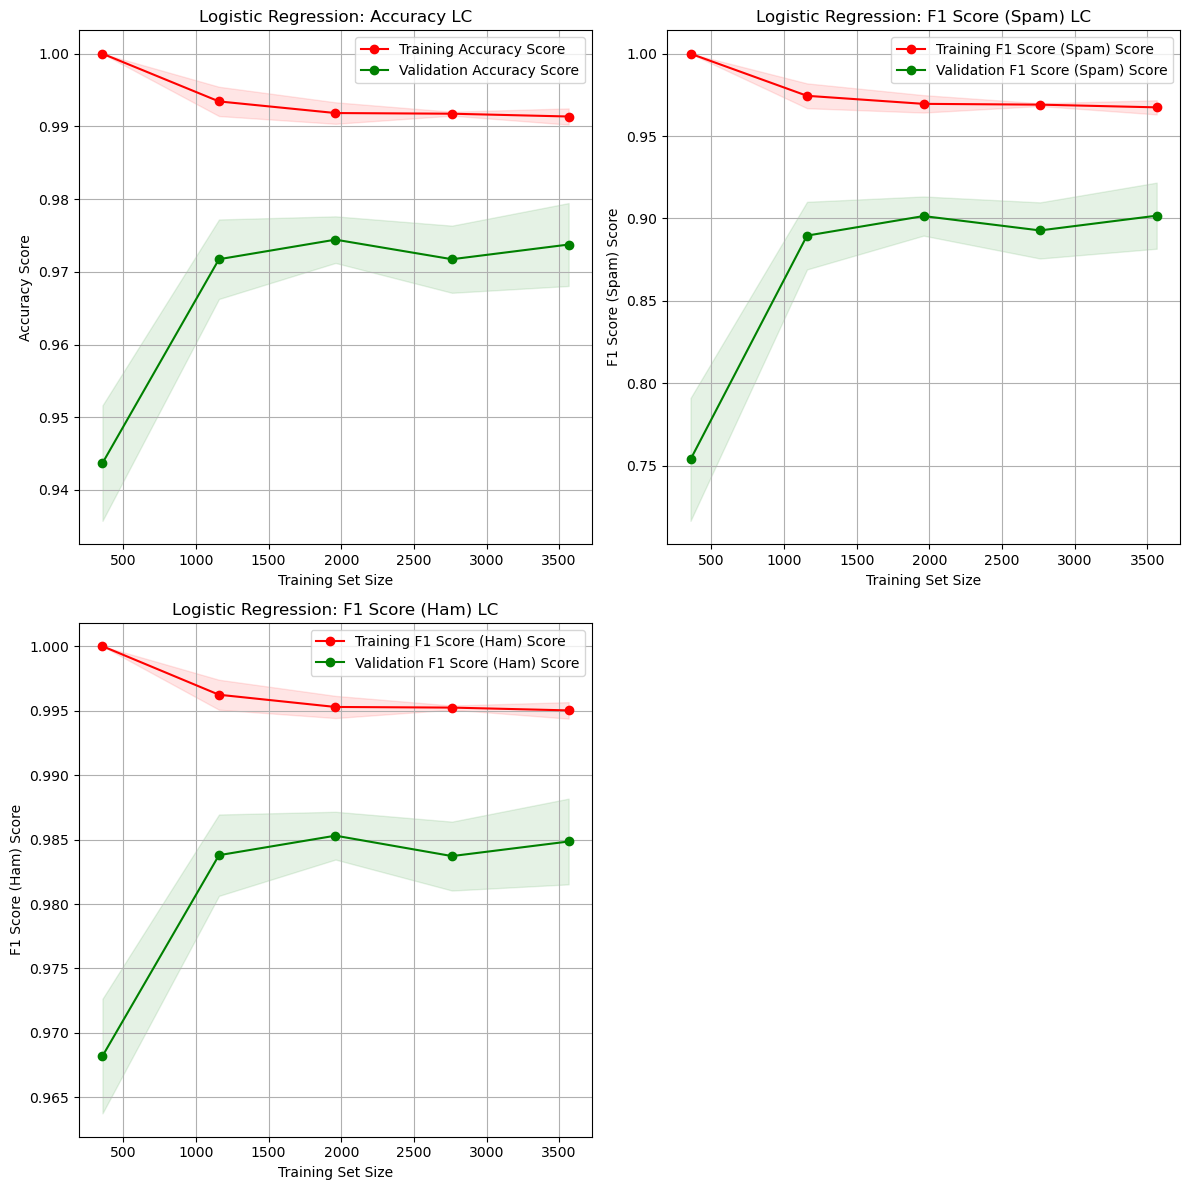

In [8]:
# Plot the learning curves
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Flatten the axes array for easier iteration
axs = axs.flatten()
count = 0
for key, value in lc_dict.items():
    axs[count].set_title(f"Logistic Regression: {key} LC")
    axs[count].set_xlabel("Training Set Size")
    axs[count].set_ylabel(f"{key} Score")
    axs[count].grid()

    axs[count].fill_between(value[3], value[1][0], value[1][1], alpha=0.1, color="r")
    axs[count].fill_between(value[3], value[2][0], value[2][1], alpha=0.1, color="g")
    axs[count].plot(value[3], value[0][0], 'o-', color="r", label=f"Training {key} Score")
    axs[count].plot(value[3], value[0][1], 'o-', color="g", label=f"Validation {key} Score")
    axs[count].legend(loc="best")
    count += 1
    
fig.delaxes(axs[count]) 

plt.tight_layout()
plt.show()

<h3><strong><u>Evaluation Metrics</u></strong></h3>

In [9]:
for key, value in clf_metrics.items():
    print(f"{key}")
    log_training_values = cross_val_score(log_model, X_train, y_train, scoring=value, cv=5)
    print("CV Training Scores: ", log_training_values)
    np_log_training_values = np.array(log_training_values)
    average = np.mean(np_log_training_values)
    stDev = np.std(np_log_training_values)
    print("Average and Standard Error: {:.2f}%".format(average.round(2)), "\u00B1", "{:.2f}%".format(stDev.round(4)*100), "\n")

Accuracy
CV Training Scores:  [0.97757848 0.96860987 0.96632997 0.97867565 0.97867565]
Average and Standard Error: 0.97% ± 0.54% 

F1 Score (Spam)
CV Training Scores:  [0.91596639 0.88709677 0.87288136 0.91914894 0.91703057]
Average and Standard Error: 0.90% ± 1.89% 

F1 Score (Ham)
CV Training Scores:  [0.98706339 0.98177083 0.98059508 0.98771816 0.98776561]
Average and Standard Error: 0.98% ± 0.31% 



Text(0.5, 1.0, 'Logistic Regression: Confusion Matrix (Evaluation)')

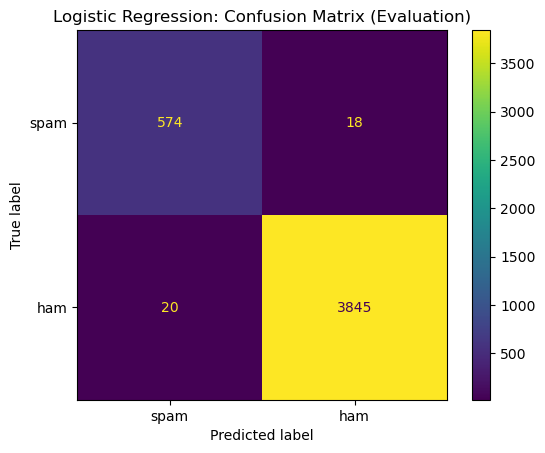

In [4]:
#Training Confusion Matrix
disp = ConfusionMatrixDisplay.from_estimator(log_model, X_train, y_train, labels=['spam', 'ham'])
disp.ax_.set_title("Logistic Regression: Confusion Matrix (Evaluation)")

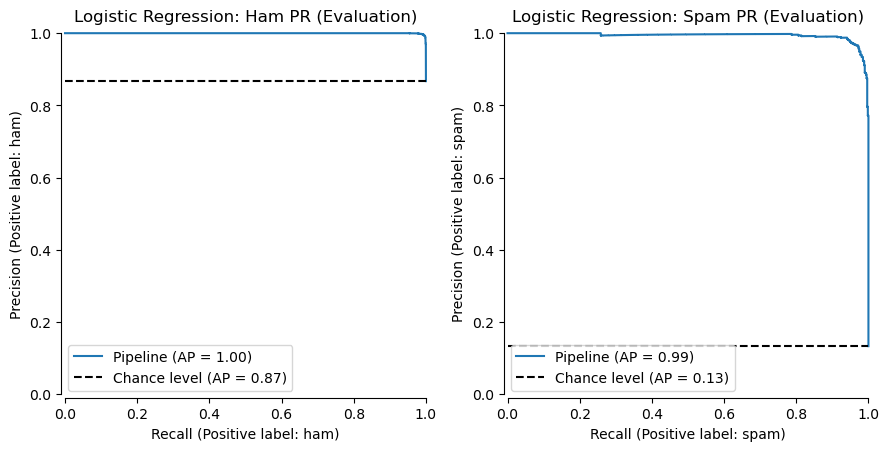

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(9, 9))
axs = axs.flatten()
count = 0
for label in train_labels:
    disp = PrecisionRecallDisplay.from_estimator(log_model, X_train, y_train, ax=axs[count], pos_label=label, plot_chance_level=True, despine=True)
    disp.ax_.set_title(f"Logistic Regression: {label.title()} PR (Evaluation)")
    count += 1

plt.tight_layout()  
plt.show()

<h4><strong><u>Findings From 'Model Evaluation' Phase</u></strong></h4>
In the evaluation of my selected model, I found positive results for all evaluation methods. The learning curves yielded good results with validation scores trending upwards with increased training sizes indicating model improvement with more data. Also, the 'cross_val_score' function results reinforced the learning curve results. In addition, the Confusion Matrix helps show that the model performed well on the training data with minimal False Negatives and False Positives. Finally, The Precision-Recall plots display a good curve that moves to the top-right corner of the plot indicating a good classifier model. Therefore, I will move forward with this model to the 'Final Model Testing' section.